In [1]:
print("Source this notebook: https://www.kaggle.com/code/fazilbtopal/model-development-and-evaluation-with-python")

Source this notebook: https://www.kaggle.com/code/fazilbtopal/model-development-and-evaluation-with-python


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F128384%2F333827%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240716%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240716T080648Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00de924eb43830c3bea621dc4f4b394b19614688cb7063c99a04c0f585b693d44461b91627f1b9d77bfb032f92c90a84ecb612b02ad5ed489596d1cf1a5a4edb280163b1dc47addae550e90ac8cf8df5262bf348ba2d53925a0cd974858a2e77d6426286ba8135e0c747f9b2aa2a4da121cf90c23130930bd54b2e0b91931c1d4606cae526d3678d7c3f8a05eef973df723b1731bb60c25e415919c0e2ba72ceb5ad105cc16e874d60734270f4317f2b860722171392bcbcc573ea829ee0204b59e36de4d4fd7cf0c757772c13db490799927eea112b456bcfe765fd70f0aace4b586672b1d7cd440214bbc2962f420f3febc31286379d6de539a0e6730d16e2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 11078 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


<h1>Model Development</h1>

<p>In this section, we will develop several models that will predict the price of the car using the variables or features. This is just an estimate but should give us an objective idea of how much the car should cost.</p>

Some questions we want to ask in this kernel
<ul>
    <li>do I know if the dealer is offering fair value for my trade-in?</li>
    <li>do I know if I put a fair value on my car?</li>
</ul>
<p>Data Analytics, we often use <b>Model Development</b> to help us predict future observations from the data we have.</p>

<p>A Model will help us understand the exact relationship between different variables and how these variables are used to predict the result.</p>

<h4>Setup</h4>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.html import widgets
from ipywidgets import interact, interactive, fixed, interact_manual

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [4]:
df = pd.read_csv('../input/auto_clean.csv')
df.head()

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,...,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,...,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,1,122,alfa-romero,std,two,hatchback,rwd,front,94.5,0.822681,...,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,2,164,audi,std,four,sedan,fwd,front,99.8,0.848630,...,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,2,164,audi,std,four,sedan,4wd,front,99.4,0.848630,...,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


<h2>1. Linear Regression and Multiple Linear Regression</h2>

<h3>Linear Regression</h3>


<p>One example of a Data  Model that we will be using is</p>

<b>Simple Linear Regression</b>.

<br>
<p>Simple Linear Regression is a method to help us understand the relationship between two variables:</p>
<ul>
    <li>The predictor/independent variable (X)</li>
    <li>The response/dependent variable (that we want to predict)(Y)</li>
</ul>

<p>The result of Linear Regression is a <b>linear function</b> that predicts the response (dependent) variable as a function of the predictor (independent) variable.</p>



$$
 Y: Response \ Variable\\
 X: Predictor \ Variables
$$


 <b>Linear function:</b>
$$
Yhat = a + b  X
$$

<ul>
    <li>a refers to the <b>intercept</b> of the regression line0, in other words: the value of Y when X is 0</li>
    <li>b refers to the <b>slope</b> of the regression line, in other words: the value with which Y changes when X increases by 1 unit</li>
</ul>

<h4>Lets load the modules for linear regression</h4>

In [5]:
from sklearn.linear_model import LinearRegression

<h4>Create the linear regression object</h4>

In [6]:
lm = LinearRegression()
lm

LinearRegression()

<h4>How could Highway-mpg help us predict car price?</h4>

For this example, we want to look at how highway-mpg can help us predict car price.
Using simple linear regression, we will create a linear function with "highway-mpg" as the predictor variable and the "price" as the response variable.

In [7]:
X = df[['highway-mpg']]
Y = df['price']

Fit the linear model using highway-mpg.

In [8]:
lm.fit(X,Y)

LinearRegression()

 We can output a prediction

In [9]:
Yhat = lm.predict(X)
Yhat[0:5]

array([16236.50464347, 16236.50464347, 17058.23802179, 13771.3045085 ,
       20345.17153508])

<h4>What is the value of the intercept (a)?</h4>

In [10]:
lm.intercept_

38423.3058581574

<h4>What is the value of the Slope (b)?</h4>

In [11]:
lm.coef_

array([-821.73337832])

<h3>What is the final estimated linear model we get?</h3>

As we saw above, we should get a final linear model with the structure:

$$
Yhat = a + b  X
$$

Plugging in the actual values we get:

<b>price</b> = 38423.31 - 821.73 x  <b>highway-mpg</b>

<h3>Multiple Linear Regression</h3>

<p>What if we want to predict car price using more than one variable?</p>

<p>If we want to use more variables in our model to predict car price, we can use <b>Multiple Linear Regression</b>.
Multiple Linear Regression is very similar to Simple Linear Regression, but this method is used to explain the relationship between one continuous response (dependent) variable and <b>two or more</b> predictor (independent) variables.
Most of the real-world regression models involve multiple predictors. We will illustrate the structure by using four predictor variables, but these results can generalize to any integer:</p>

$$
Y: Response \ Variable\\
X_1 :Predictor\ Variable \ 1\\
X_2: Predictor\ Variable \ 2\\
X_3: Predictor\ Variable \ 3\\
X_4: Predictor\ Variable \ 4\\
$$

$$
a: intercept\\
b_1 :coefficients \ of\ Variable \ 1\\
b_2: coefficients \ of\ Variable \ 2\\
b_3: coefficients \ of\ Variable \ 3\\
b_4: coefficients \ of\ Variable \ 4\\
$$

The equation is given by

$$
Yhat = a + b_1 X_1 + b_2 X_2 + b_3 X_3 + b_4 X_4
$$

<p>From the previous section  we know that other good predictors of price could be:</p>
<ul>
    <li>Horsepower</li>
    <li>Curb-weight</li>
    <li>Engine-size</li>
    <li>Highway-mpg</li>
</ul>
Let's develop a model using these variables as the predictor variables.

In [12]:
Z = df[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']]

Fit the linear model using the four above-mentioned variables.

In [13]:
lm.fit(Z, df['price'])

LinearRegression()

What is the value of the intercept(a)?

In [14]:
lm.intercept_

-15806.62462632922

What are the values of the coefficients (b1, b2, b3, b4)?

In [15]:
lm.coef_

array([53.49574423,  4.70770099, 81.53026382, 36.05748882])

 What is the final estimated linear model that we get?

As we saw above, we should get a final linear function with the structure:

$$
Yhat = a + b_1 X_1 + b_2 X_2 + b_3 X_3 + b_4 X_4
$$

What is the linear function we get in this example?

<b>Price</b> = -15678.742628061467 + 52.65851272 x <b>horsepower</b> + 4.69878948 x <b>curb-weight</b> + 81.95906216 x <b>engine-size</b> + 33.58258185 x <b>highway-mpg</b>

<h2>2)  Model Evaluation using Visualization</h2>

Now that we've developed some models, how do we evaluate our models and how do we choose the best one? One way to do this is by using visualization.

In [16]:
import seaborn as sns
%matplotlib inline

<h3>Regression Plot</h3>

<p>When it comes to simple linear regression, an excellent way to visualize the fit of our model is by using <b>regression plots</b>.</p>

<p>This plot will show a combination of a scattered data points (a <b>scatter plot</b>), as well as the fitted <b>linear regression</b> line going through the data. This will give us a reasonable estimate of the relationship between the two variables, the strength of the correlation, as well as the direction (positive or negative correlation).</p>

 Let's visualize Horsepower as potential predictor variable of price:

(0.0, 48177.352968321284)

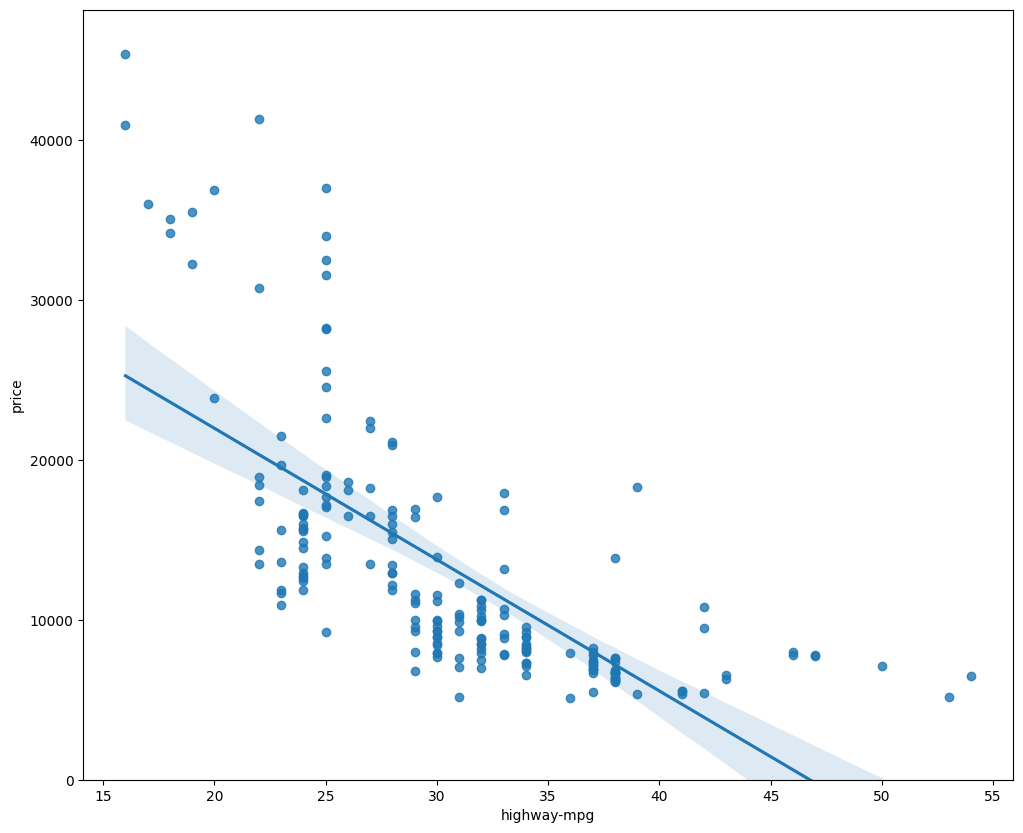

In [17]:
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="highway-mpg", y="price", data=df)
plt.ylim(0,)

<p>We can see from this plot that price is negatively correlated to highway-mpg, since the regression slope is negative.
One thing to keep in mind when looking at a regression plot is to pay attention to how scattered the data points are around the regression line. This will give you a good indication of the variance of the data, and whether a linear model would be the best fit or not. If the data is too far off from the line, this linear model might not be the best model for this data. Let's compare this plot to the regression plot of "peak-rpm".</p>

(0.0, 47414.1)

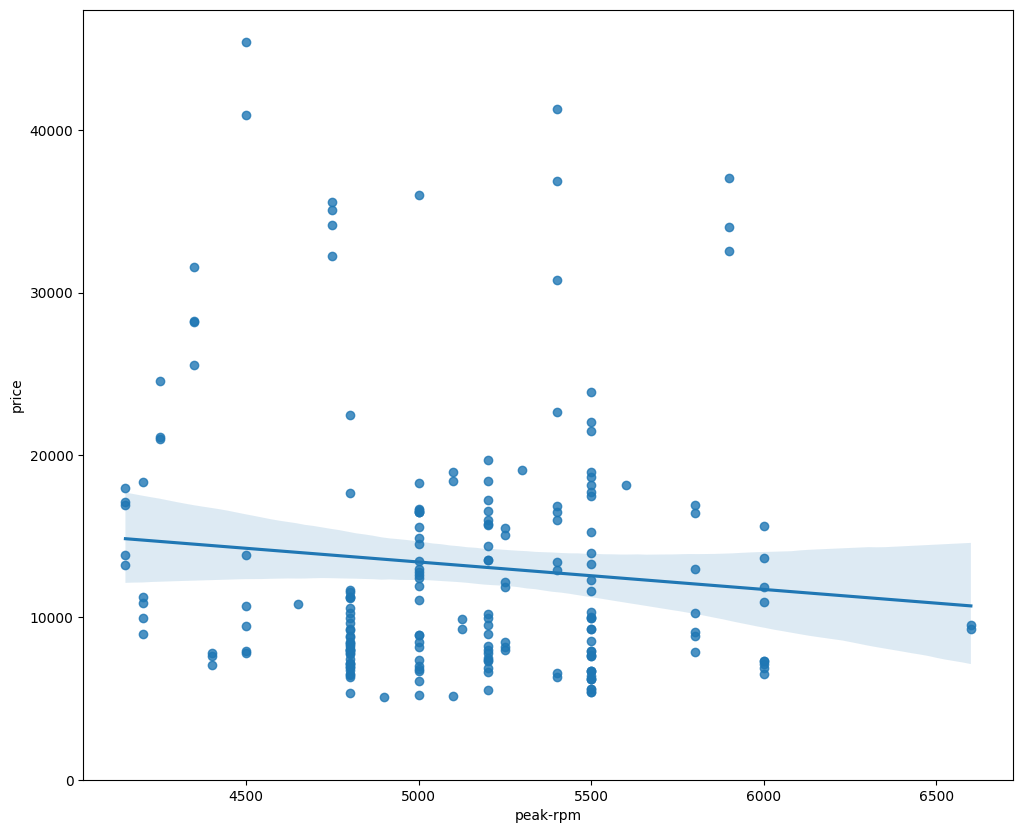

In [18]:
plt.figure(figsize=(width, height))
sns.regplot(x="peak-rpm", y="price", data=df)
plt.ylim(0,)

<p>Comparing the regression plot of "peak-rpm" and "highway-mpg" we see that the points for "highway-mpg" are much closer to the generated line and on the average decrease. The points for "peak-rpm" have more spread around the predicted line, and it is much harder to determine if the points are decreasing or increasing as the "highway-mpg" increases.</p>

<b>Given the regression plots above is "peak-rpm" or "highway-mpg" more strongly correlated with "price"?.</b>

In [19]:
#The variable "peak-rpm" has a stronger correlation with "price",
# it is approximate -0.704692  compared to   "highway-mpg" which is approximate -0.101616.

df[["peak-rpm","highway-mpg","price"]].corr()

,peak-rpm,highway-mpg,price
peak-rpm,1.000000,-0.058598,-0.101616
highway-mpg,-0.058598,1.000000,-0.704692
price,-0.101616,-0.704692,1.000000


<h3>Residual Plot</h3>

<p>A good way to visualize the variance of the data is to use a residual plot.</p>

<p>What is a <b>residual</b>?</p>

<p>The difference between the observed value (y) and the predicted value (Yhat) is called the residual (e). When we look at a regression plot, the residual is the distance from the data point to the fitted regression line.</p>

<p>So what is a <b>residual plot</b>?</p>

<p>A residual plot is a graph that shows the residuals on the vertical y-axis and the independent variable on the horizontal x-axis.</p>

<p>What do we pay attention to when looking at a residual plot?</p>

<p>We look at the spread of the residuals:</p>

<p>- If the points in a residual plot are <b>randomly spread out around the x-axis</b>, then a <b>linear model is appropriate</b> for the data. Why is that? Randomly spread out residuals means that the variance is constant, and thus the linear model is a good fit for this data.</p>

<Axes: xlabel='highway-mpg', ylabel='price'>

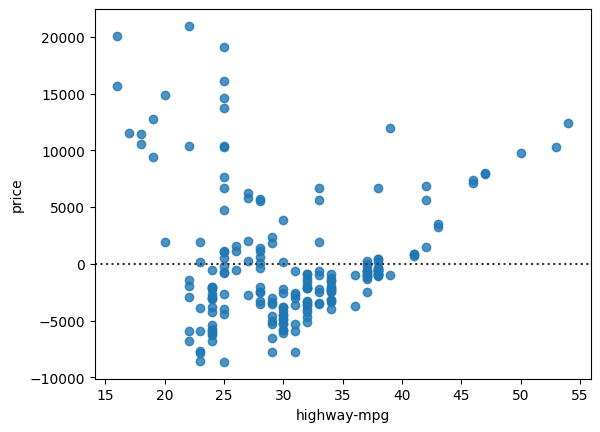

In [20]:
sns.residplot(x=df['highway-mpg'], y=df['price'])

<i>What is this plot telling us?</i>

<p>We can see from this residual plot that the residuals are not randomly spread around the x-axis, which leads us to believe that maybe a non-linear model is more appropriate for this data.</p>

<h3>Multiple Linear Regression</h3>

<p>How do we visualize a model for Multiple Linear Regression? This gets a bit more complicated because you can't visualize it with regression or residual plot.</p>

<p>One way to look at the fit of the model is by looking at the <b>distribution plot</b>: We can look at the distribution of the fitted values that result from the model and compare it to the distribution of the actual values.</p>

First lets make a prediction

In [21]:
Y_hat = lm.predict(Z)

<ipython-input-22-c9a28b8cc0b1>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(df['price'], hist=False, color="r", label="Actual Value")
<ipython-input-22-c9a28b8cc0b1>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" ,

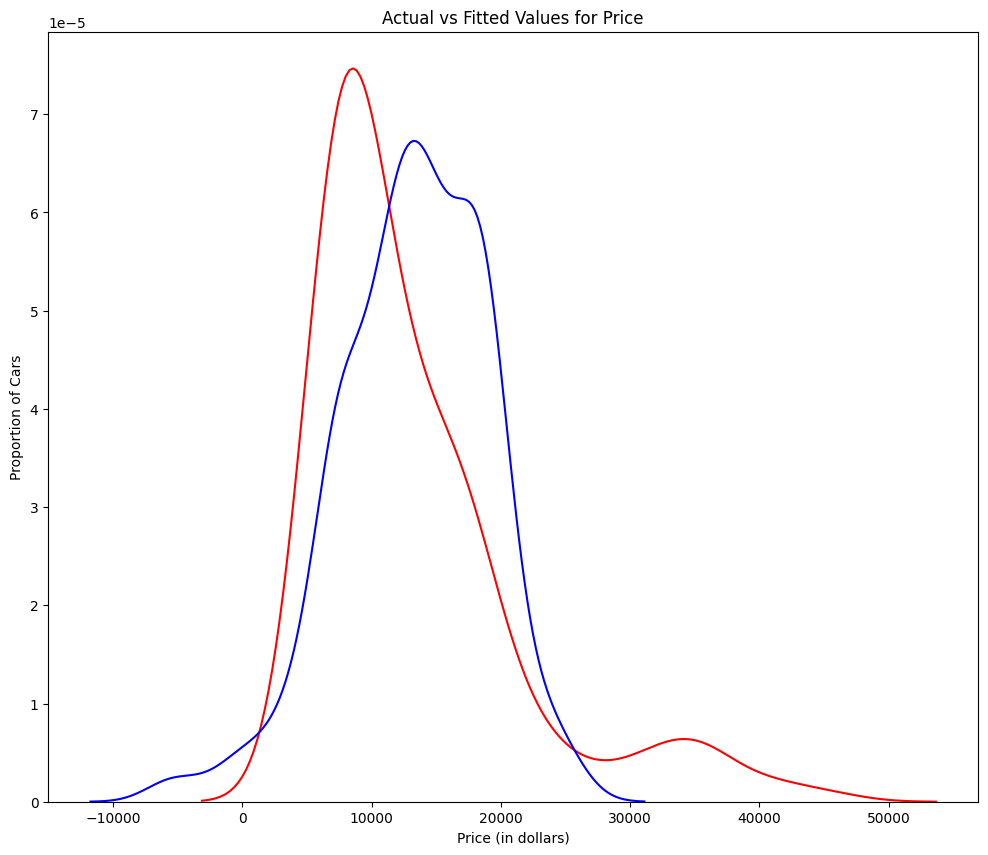

In [22]:
plt.figure(figsize=(width, height))


ax1 = sns.distplot(df['price'], hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

<p>We can see that the fitted values are reasonably close to the actual values, since the two distributions overlap a bit. However, there is definitely some room for improvement.</p>

<h2>3) Polynomial Regression and Pipelines</h2>

<p><b>Polynomial regression</b> is a particular case of the general linear regression model or multiple linear regression models.</p>
<p>We get non-linear relationships by squaring or setting higher-order terms of the predictor variables.</p>

<p>There are different orders of polynomial regression:</p>

<center><b>Quadratic - 2nd order</b></center>
$$Yhat = a + b_1 X^2 +b_2 X^2\\$$  
  
<center><b>Cubic - 3rd order</b></center>
$$Yhat = a + b_1 X^2 +b_2 X^2 +b_3 X^3\\$$

<center><b>Higher order</b></center>
$$Y = a + b_1 X^2 +b_2 X^2 +b_3 X^3 ....\\$$

<p>We saw earlier that a linear model did not provide the best fit while using highway-mpg as the predictor variable. Let's see if we can try fitting a polynomial model to the data instead.</p>

<p>We will use the following function to plot the data:</p>

In [23]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(15, 55, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Price ~ Length')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Price of Cars')

    plt.show()
    plt.close()

lets get the variables

In [24]:
x = df['highway-mpg']
y = df['price']

Let's fit the polynomial using the function <b>polyfit</b>, then use the function <b>poly1d</b> to display the polynomial function.

In [25]:
# Here we use a polynomial of the 3rd order (cubic)
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

        3         2
-1.557 x + 204.8 x - 8965 x + 1.379e+05


 Let's plot the function

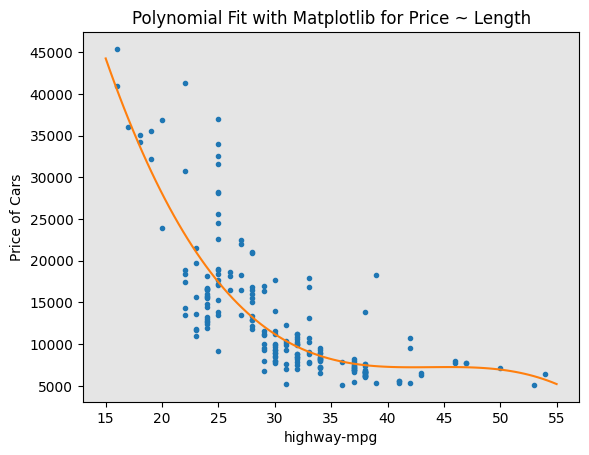

In [26]:
PlotPolly(p, x, y, 'highway-mpg')

In [27]:
np.polyfit(x, y, 3)

array([-1.55663829e+00,  2.04754306e+02, -8.96543312e+03,  1.37923594e+05])

<p>We can already see from plotting that this polynomial model performs better than the linear model. This is because the generated polynomial function  "hits" more of the data points.</p>

<p>The analytical expression for Multivariate Polynomial function gets complicated. For example, the expression for a second-order (degree=2)polynomial with two variables is given by:</p>

$$
Yhat = a + b_1 X_1 +b_2 X_2 +b_3 X_1 X_2+b_4 X_1^2+b_5 X_2^2
$$

We can perform a polynomial transform on multiple features. First, we import the module:

In [28]:
from sklearn.preprocessing import PolynomialFeatures

We create a <b>PolynomialFeatures</b> object of degree 2:

In [29]:
pr = PolynomialFeatures(degree=2)
pr

PolynomialFeatures()

In [30]:
Z_pr = pr.fit_transform(Z)

The original data is of 201 samples and 4 features

In [31]:
Z.shape

(201, 4)

after the transformation, there 201 samples and 15 features

In [32]:
Z_pr.shape

(201, 15)

<h2>Pipeline</h2>

<p>Data Pipelines simplify the steps of processing the data. We use the module <b>Pipeline</b> to create a pipeline. We also use <b>StandardScaler</b> as a step in our pipeline.</p>

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We create the pipeline, by creating a list of tuples including the name of the model or estimator and its corresponding constructor.

In [34]:
Input=[('scale', StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)),
       ('model', LinearRegression())]

we input the list as an argument to the pipeline constructor

In [35]:
pipe = Pipeline(Input)
pipe

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

We can normalize the data,  perform a transform and fit the model simultaneously.

In [36]:
pipe.fit(Z,y)

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

 Similarly,  we can normalize the data, perform a transform and produce a prediction  simultaneously

In [37]:
ypipe=pipe.predict(Z)
ypipe[0:4]

array([13102.74784201, 13102.74784201, 18225.54572197, 10390.29636555])

<h2>4) Measures for In-Sample Evaluation</h2>

<p>When evaluating our models, not only do we want to visualize the results, but we also want a quantitative measure to determine how accurate the model is.</p>

<p>Two very important measures that are often used in Statistics to determine the accuracy of a model are:</p>
<ul>
    <li><b>R^2 / R-squared</b></li>
    <li><b>Mean Squared Error (MSE)</b></li>
</ul>
    
<b>R-squared</b>

<p>R squared, also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line.</p>
    
<p>The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.</p>


<b>Mean Squared Error (MSE)</b>

<p>The Mean Squared Error measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).</p>

<h4>Model 1: Simple Linear Regression</h4>

Let's calculate the R^2

In [38]:
# highway_mpg_fit
lm.fit(X, Y)

# Find the R^2
print('The R-square is: ', lm.score(X, Y))

The R-square is:  0.4965911884339176


We can say that ~ 49.659% of the variation of the price is explained by this simple linear model "horsepower_fit".

Let's calculate the MSE

We can predict the output i.e., "yhat" using the predict method, where X is the input variable:

In [39]:
Yhat = lm.predict(X)
print('The output of the first four predicted value is: ', Yhat[0:4])

The output of the first four predicted value is:  [16236.50464347 16236.50464347 17058.23802179 13771.3045085 ]


lets import the function <b>mean_squared_error</b> from the module <b>metrics</b>

In [40]:
from sklearn.metrics import mean_squared_error

we compare the predicted results with the actual results

In [41]:
mse = mean_squared_error(df['price'], Yhat)
print('The mean square error of price and predicted value is: ', mse)

The mean square error of price and predicted value is:  31635042.944639888


<h3>Model 2: Multiple Linear Regression</h3>

Let's calculate the R^2

In [42]:
# fit the model
lm.fit(Z, df['price'])

# Find the R^2
print('The R-square is: ', lm.score(Z, df['price']))

The R-square is:  0.8093562806577457


We can say that ~ 80.896 % of the variation of price is explained by this multiple linear regression "multi_fit".

Let's calculate the MSE

 we produce a prediction

In [43]:
Y_predict_multifit = lm.predict(Z)

 we compare the predicted results with the actual results

In [44]:
print('The mean square error of price and predicted value using multifit is: ', \
      mean_squared_error(df['price'], Y_predict_multifit))

The mean square error of price and predicted value using multifit is:  11980366.87072649


<h3>Model 3: Polynomial Fit</h3>

Let's calculate the R^2

let’s import the function <b>r2_score</b> from the module <b>metrics</b> as we are using a different function

In [45]:
from sklearn.metrics import r2_score

We apply the function to get the value of r^2

In [46]:
r_squared = r2_score(y, p(x))
print('The R-square value is: ', r_squared)

The R-square value is:  0.674194666390652


We can say that ~ 67.419 % of the variation of price is explained by this polynomial fit

<h3>MSE</h3>

We can also calculate the MSE:  

In [47]:
mean_squared_error(df['price'], p(x))

20474146.426361218

<h2>5) Prediction and Decision Making</h2>
<h3>Prediction</h3>

<p>In the previous section, we trained the model using the method <b>fit</b>. Now we will use the method <b>predict</b> to produce a prediction.

Create a new input

In [48]:
new_input = np.arange(1, 100, 1).reshape(-1, 1)

 Fit the model

In [49]:
lm.fit(X, Y)
lm

LinearRegression()

Produce a prediction

In [50]:
yhat=lm.predict(new_input)
yhat[0:5]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([37601.57247984, 36779.83910151, 35958.10572319, 35136.37234487,
       34314.63896655])

we can plot the data

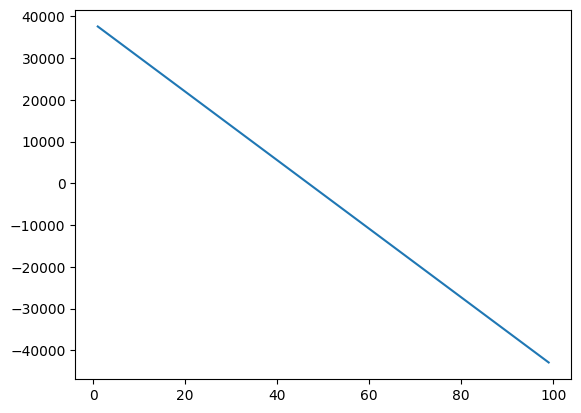

In [51]:
plt.plot(new_input, yhat)
plt.show()

<h3>Decision Making: Determining a Good Model Fit</h3>

<p>Now that we have visualized the different models, and generated the R-squared and MSE values for the fits, how do we determine a good model fit?
<ul>
    <li><i>What is a good R-squared value?</i></li>
</ul>
</p>

<p>When comparing models, <b>the model with the higher R-squared value is a better fit</b> for the data.
<ul>
    <li><i>What is a good MSE?</i></li>
</ul>
</p>

<p>When comparing models, <b>the model with the smallest MSE value is a better fit</b> for the data.</p>


<h4>Let's take a look at the values for the different models.</h4>
<p>Simple Linear Regression: Using Highway-mpg as a Predictor Variable of Price.
<ul>
    <li>R-squared: 0.49659118843391759</li>
    <li>MSE: 3.16 x10^7</li>
</ul>
</p>
    
<p>Multiple Linear Regression: Using Horsepower, Curb-weight, Engine-size, and Highway-mpg as Predictor Variables of Price.
<ul>
    <li>R-squared: 0.80896354913783497</li>
    <li>MSE: 1.2 x10^7</li>
</ul>
</p>
    
<p>Polynomial Fit: Using Highway-mpg as a Predictor Variable of Price.
<ul>
    <li>R-squared: 0.6741946663906514</li>
    <li>MSE: 2.05 x 10^7</li>
</ul>
</p>

<h3>Simple Linear Regression model (SLR) vs Multiple Linear Regression model (MLR)</h3>

<p>Usually, the more variables you have, the better your model is at predicting, but this is not always true. Sometimes you may not have enough data, you may run into numerical problems, or many of the variables may not be useful and or even act as noise. As a result, you should always check the MSE and R^2.</p>

<p>So to be able to compare the results of the MLR vs SLR models, we look at a combination of both the R-squared and MSE to make the best conclusion about the fit of the model.
<ul>
    <li><b>MSE</b>The MSE of SLR is  3.16x10^7  while MLR has an MSE of 1.2 x10^7.  The MSE of MLR is much smaller.</li>
    <li><b>R-squared</b>: In this case, we can also see that there is a big difference between the R-squared of the SLR and the R-squared of the MLR. The R-squared for the SLR (~0.497) is very small compared to the R-squared for the MLR (~0.809).</li>
</ul>
</p>

This R-squared in combination with the MSE show that MLR seems like the better model fit in this case, compared to SLR.

<h3>Simple Linear Model (SLR) vs Polynomial Fit</h3>

<ul>
    <li><b>MSE</b>: We can see that Polynomial Fit brought down the MSE, since this MSE is smaller than the one from the SLR.</li>
    <li><b>R-squared</b>: The R-squared for the Polyfit is larger than the R-squared for the SLR, so the Polynomial Fit also brought up the R-squared quite a bit.</li>
</ul>
<p>Since the Polynomial Fit resulted in a lower MSE and a higher R-squared, we can conclude that this was a better fit model than the simple linear regression for predicting Price with Highway-mpg as a predictor variable.</p>

<h3>Multiple Linear Regression (MLR) vs Polynomial Fit</h3>

<ul>
    <li><b>MSE</b>: The MSE for the MLR is smaller than the MSE for the Polynomial Fit.</li>
    <li><b>R-squared</b>: The R-squared for the MLR is also much larger than for the Polynomial Fit.</li>
</ul>

<h2>Conclusions on Model Development:</h2>

<p>Comparing these three models, we conclude that <b>the MLR model is the best model</b> to be able to predict price from our dataset. This result makes sense, since we have 27 variables in total, and we know that more than one of those variables are potential predictors of the final car price.</p>

<h1> Model Evaluation and Refinement</h1>

We have built models and made predictions of vehicle prices. Now we will determine how accurate these predictions are.

In [52]:
df._get_numeric_data().head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


In [53]:
# First lets only use numeric data
df = df._get_numeric_data()

### Functions for Plotting

In [54]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [55]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr, poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    #training data
    #testing data
    # lr:  linear regression object
    #poly_transform:  polynomial transformation object

    xmax=max([xtrain.values.max(), xtest.values.max()])
    xmin=min([xtrain.values.min(), xtest.values.min()])
    x=np.arange(xmin, xmax, 0.1)

    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))),
             label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

<h2>Part 1: Training and Testing</h2>

<p>An important step in testing your model is to split your data into training and testing data. We will place the target data <b>price</b> in a separate dataframe <b>y</b>:</p>

In [56]:
y_data = df['price']

drop price data in x data

In [57]:
x_data=df.drop('price', axis=1)

Now we randomly split our data into training and testing data  using the function <b>train_test_split</b>.

In [58]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15,
                                                    random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:", x_train.shape[0])


number of test samples : 31
number of training samples: 170


The <b>test_size</b> parameter sets the proportion of data that is split into the testing set. In the above, the testing set is set to 10% of the total dataset.

 We create a Linear Regression object:

In [59]:
lre = LinearRegression()

we fit the model using the feature horsepower

In [60]:
lre.fit(x_train[['horsepower']], y_train)

LinearRegression()

Let's Calculate the R^2 on the test data:

In [61]:
lre.score(x_test[['horsepower']], y_test)

0.707688374146705

we can see the R^2 is much smaller using the test data.

In [62]:
lre.score(x_train[['horsepower']], y_train)

0.6449517437659684

 Sometimes you do not have sufficient testing data; as a result, you may want to perform Cross-validation. Let's  go over several methods that you can use for  Cross-validation.

<h2>Cross-validation Score</h2>

Lets import <b>model_selection</b> from the module <b>cross_val_score</b>.

In [63]:
from sklearn.model_selection import cross_val_score

We input the object, the feature in this case ' horsepower', the target data (y_data). The parameter 'cv'  determines the number of folds; in this case 4.

In [64]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

The default scoring is R^2; each element in the array has the average  R^2 value in the fold:

In [65]:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

 We can calculate the average and standard deviation of our estimate:

In [66]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.522009915042119 and the standard deviation is 0.291183944475603


We can use negative squared error as a score by setting the parameter  'scoring' metric to 'neg_mean_squared_error'.

In [67]:
-1 * cross_val_score(lre,x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')

array([20254142.84026702, 43745493.2650517 , 12539630.34014931,
       17561927.72247591])

You can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, using one fold to get a prediction while the rest of the folds are used as test data. First import the function:

In [68]:
from sklearn.model_selection import cross_val_predict

We input the object, the feature in this case <b>'horsepower'</b> , the target data <b>y_data</b>. The parameter 'cv' determines the number of folds; in this case 4. We can produce an output:

In [69]:
yhat = cross_val_predict(lre, x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

<h2>Part 2: Overfitting, Underfitting and Model Selection</h2>

<p>It turns out that the test data sometimes referred to as the out of sample data is a much better measure of how well your model performs in the real world.  One reason for this is overfitting; let's go over some examples. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.</p>

Let's create Multiple linear regression objects and train the model using <b>'horsepower'</b>, <b>'curb-weight'</b>, <b>'engine-size'</b> and <b>'highway-mpg'</b> as features.

In [70]:
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression()

Prediction using training data:

In [71]:
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([11927.70699817, 11236.71672034,  6436.91775515, 21890.22064982,
       16667.18254832])

Prediction using test data:

In [72]:
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.16502418,  5914.48335385, 11243.76325987,  6662.03197043,
       15555.76936275])

Let's perform some model evaluation using our training and testing data separately and also examine the distribution of the predicted values of the training data.

<ipython-input-54-122ce36d6117>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
<ipython-input-54-122ce36d6117>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, 

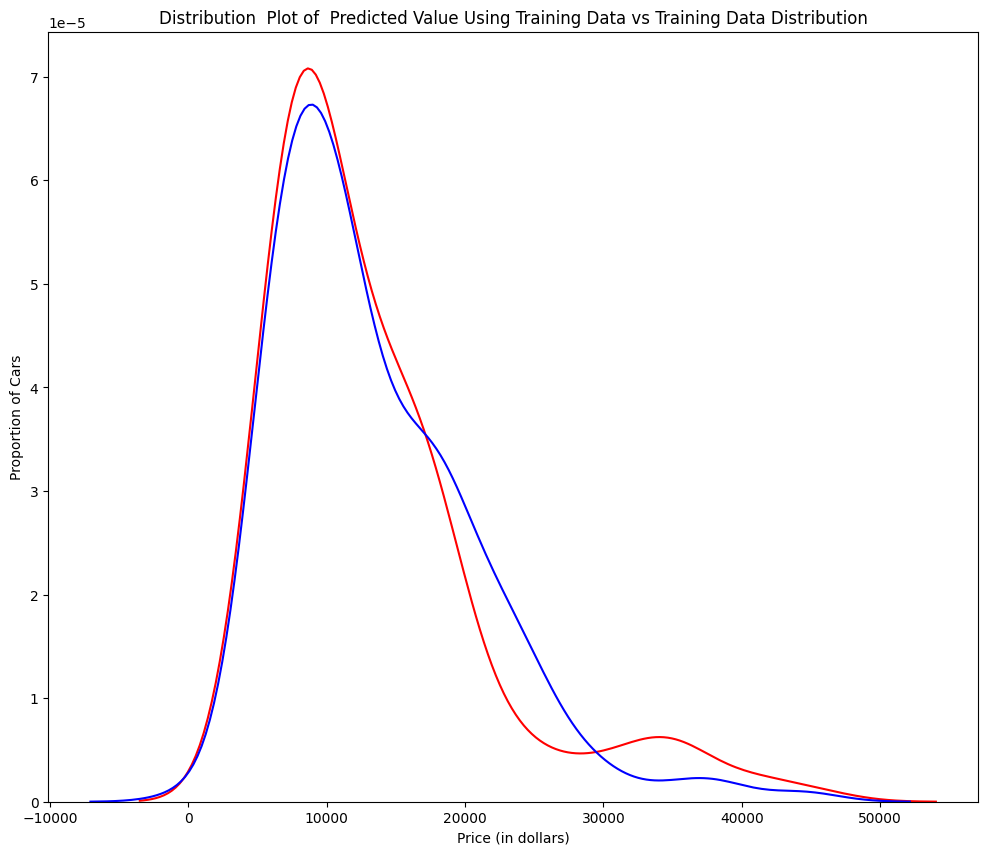

In [73]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

<p style="text-align:center"><i>Figure 1: Plot of predicted values using the training data compared to the training data.</i></p>

So far the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.

<ipython-input-54-122ce36d6117>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
<ipython-input-54-122ce36d6117>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, 

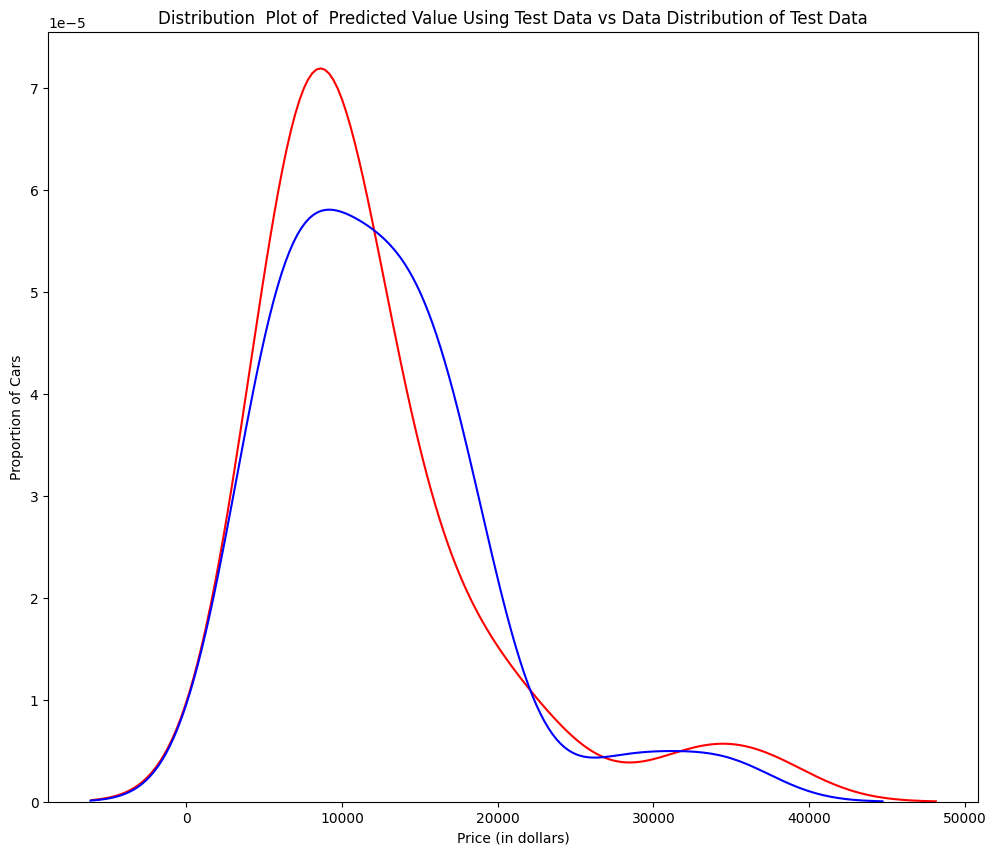

In [74]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

<p style="text-align:center"><i>Figure 2: Plot of predicted value using the test data compared to the test data.</i></p>

<p>Comparing Figure 1 and Figure 2; it is evident the distribution of the test data in Figure 1 is much better at fitting the data. This difference in Figure 2 is apparent where the ranges are from 5000 to 15 000. This is where the distribution shape is exceptionally different. Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.</p>

<h4>Overfitting</h4>
<p>Overfitting occurs when the model fits the noise, not the underlying process. Therefore when testing your model using the test-set, your model does not perform as well as it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.</p>

Let's use 55 percent of the data for testing and the rest for training:

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

We will perform a degree 5 polynomial transformation on the feature <b>'horse power'</b>.

In [76]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5)

Now let's create a linear regression model "poly" and train it.

In [77]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression()

We can see the output of our model using the method  "predict." then assign the values to "yhat".

In [78]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6728.65561887,  7307.98782321, 12213.78770965, 18893.24804015,
       19995.95195136])

Let's take the first five predicted values and compare it to the actual targets.

In [79]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.65561887  7307.98782321 12213.78770965 18893.24804015]
True values: [ 6295. 10698. 13860. 13499.]


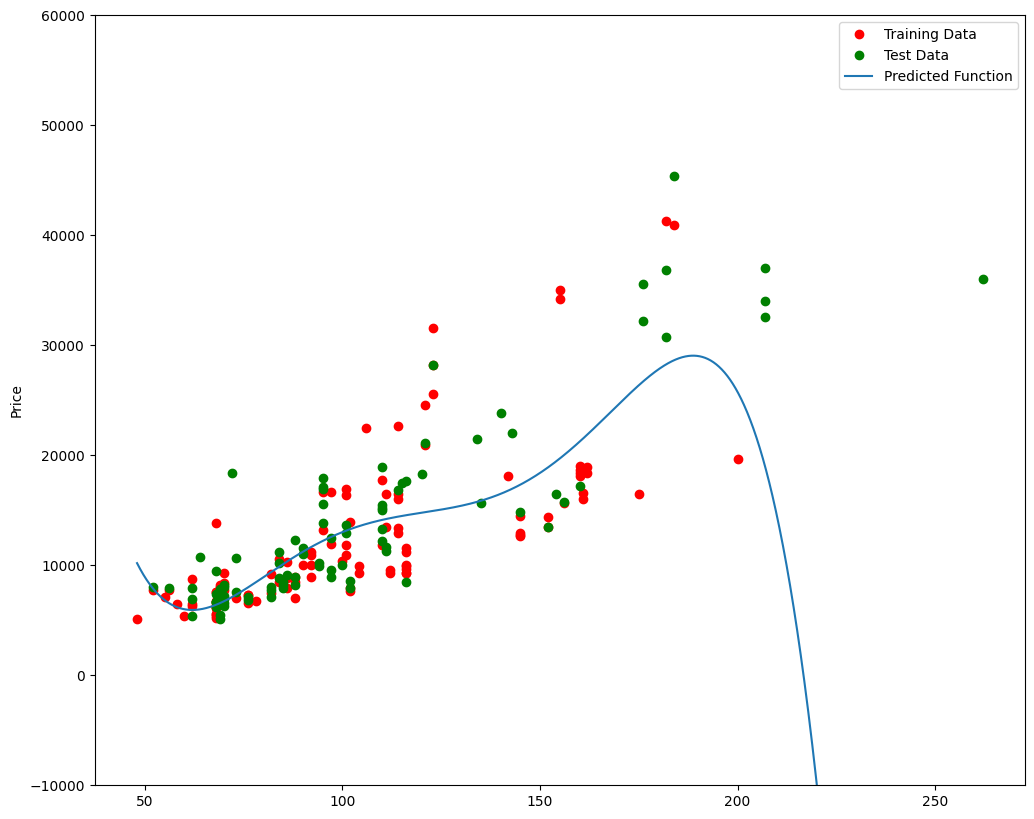

In [80]:
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)

<p style="text-align:center"><i>Figure 4: A polynomial regression model, red dots represent training data, green dots represent test data, and the blue line represents the model prediction. </i></p>


We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points.

 R^2 of the training data:

In [81]:
poly.score(x_train_pr, y_train)

0.5567716902120254

 R^2 of the test data:

In [82]:
poly.score(x_test_pr, y_test)

-29.871340302043684

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87.  The lower the R^2, the worse the model, a Negative R^2 is a sign of overfitting.

Let's see how the R^2 changes on the test data for different order polynomials and plot the results:

Text(3, 0.75, 'Maximum R^2 ')

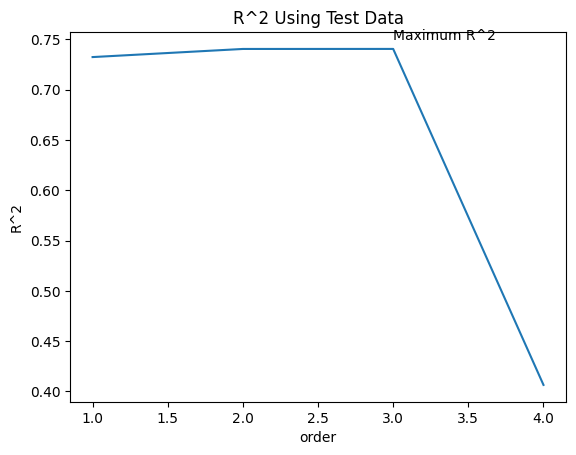

In [83]:
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)

    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])

    lr.fit(x_train_pr, y_train)
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')

We see the R^2 gradually increases until an order three polynomial is used. Then the  R^2 dramatically decreases at four. Let's create a template function which allows us to experiment on different polynomial features.

In [84]:
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

The following interface allows you to experiment with different polynomial orders and different amounts of data.

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f(order, test_data)>

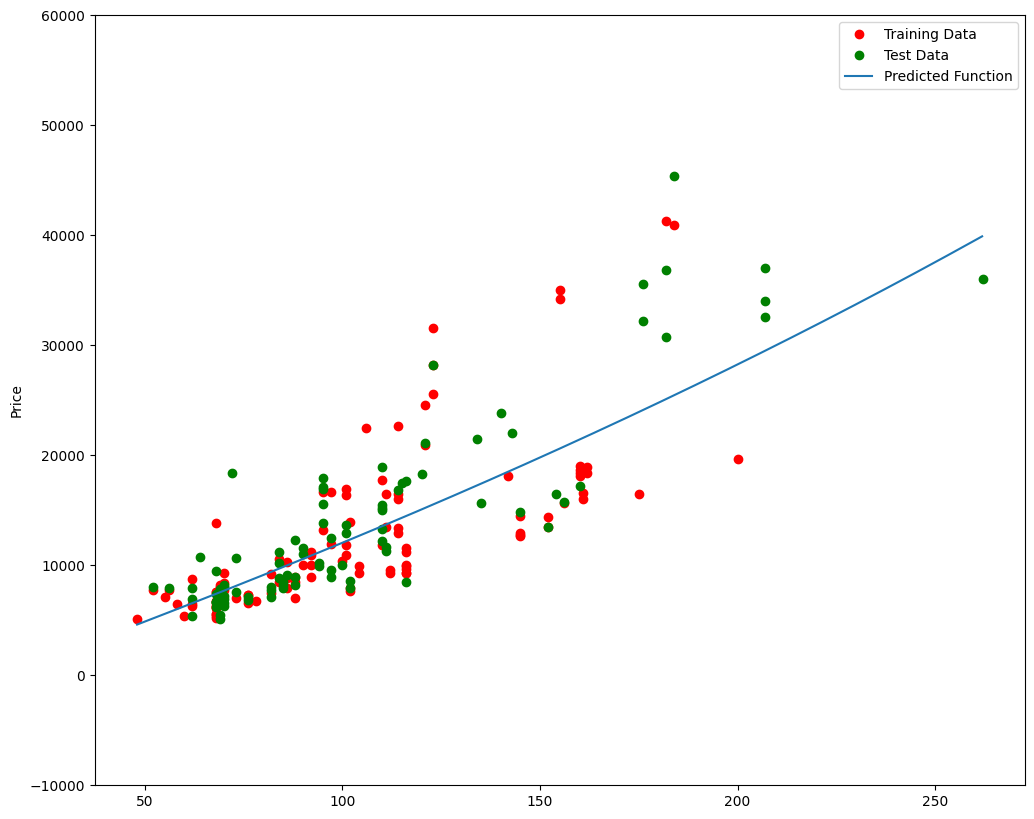

In [85]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

<h2>Part 3: Ridge regression</h2>

 In this section, we will review Ridge Regression we will see how the parameter Alfa changes the model. Just a note here our test data will be used as validation data.

 Let's perform a degree two polynomial transformation on our data.

In [86]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size',
                                       'highway-mpg','normalized-losses','symboling']])
x_test_pr = pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size',
                                     'highway-mpg','normalized-losses','symboling']])

 Let's import  <b>Ridge</b>  from the module <b>linear models</b>.

In [87]:
from sklearn.linear_model import Ridge

Let's create a Ridge regression object, setting the regularization parameter to 0.1

In [88]:
RigeModel = Ridge(alpha=0.1)

Like regular regression, you can fit the model using the method <b>fit</b>.

In [89]:
RigeModel.fit(x_train_pr, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02972e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.1)

In [90]:
yhat = RigeModel.predict(x_test_pr)

Let's compare the first five predicted samples to our test set

In [91]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6567.83081933  9597.97151399 20836.22326843 19347.69543463]
test set : [ 6295. 10698. 13860. 13499.]


We select the value of Alfa that minimizes the test error, for example, we can use a for loop.

In [92]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
ALFA = 10 * np.array(range(0,1000))
for alfa in ALFA:
    RigeModel = Ridge(alpha=alfa)
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))

We can plot out the value of R^2 for different Alphas

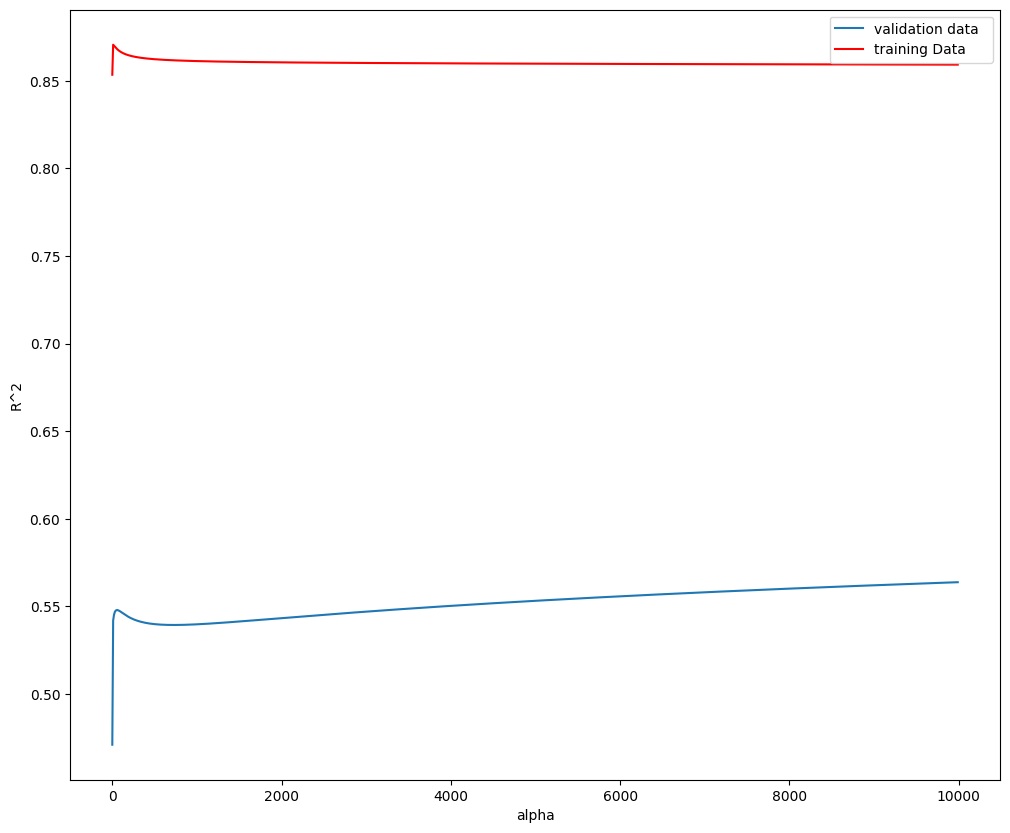

In [93]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(ALFA,Rsqu_test, label='validation data  ')
plt.plot(ALFA,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

The red line in figure 6 represents the  R^2 of the test data, as Alpha increases the R^2 decreases; therefore as Alfa increases the model performs worse on the test data.  The blue line represents the R^2 on the validation data, as the value for Alfa increases the R^2 decreases.   

<h2>Part 4: Grid Search</h2>

The term Alfa is a hyperparameter, sklearn has the class  <b>GridSearchCV</b> to make the process of finding the best hyperparameter simpler.

Let's import <b>GridSearchCV</b> from  the module <b>model_selection</b>.

In [94]:
from sklearn.model_selection import GridSearchCV

We create a dictionary of parameter values:

In [95]:
parameters1 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

Create a ridge regions object:

In [96]:
RR = Ridge()
RR

Ridge()

Create a ridge grid search object

In [97]:
Grid1 = GridSearchCV(RR, parameters1, cv=4)

In [98]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable BestRR as follows:

In [104]:
BestRR = Grid1.best_estimator_
BestRR

Ridge(alpha=10000)

 We now test our model on the test data

In [100]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.8411649831036151

We can also add more parameters to GridSearch as this will try all combinations of different parameters and return the best result for us

In [107]:
parameters2 = [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'random_state': [42]} ]
Grid2 = GridSearchCV(Ridge(), parameters2, cv=4)
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
print(Grid2.best_estimator_)

Ridge(alpha=10000, random_state=42)


In [108]:
Grid2.best_estimator_.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.8411649831036151

## Conclusions

I hope you enjoyed my kernel. I would like to hear your thoughts on my kernels if you liked it!